<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Tutorial_I_Dflat_Field_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone D$\flat$ Repository and Install

D$\flat$ is a relatively large package as it contains raw data files for nanocell libraries and pre-trained neural models. It may take a few minutes to download

In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Updated git hooks.
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 3241, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 3241 (delta 93), reused 223 (delta 80), pack-reused 2977
Receiving objects: 100% (3241/3241), 1.02 GiB | 18.55 MiB/s, done.
Resolving deltas: 100% (1149/1149), done.
Updating files: 100% (357/357), done.
Filtering content: 100% (19/19), 77.92 MiB | 50.37 MiB/s, done.
/content/DFlat
running develop
running egg_info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
reading manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/DFlat.egg-link (link to .)
DFlat 2.3.0 is already the active version in easy

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Defining the propagation parameters object

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import dflat.plot_utilities as df_plt
import dflat.fourier_layer as df_fourier
import dflat.data_structure as df_struct

To use any propagation or point-spread function instance in D$\flat$, one must first begin by defining the propagation_parameters dictionary object. This defines the settings used in the calculations and manages the back-end code. 


Some notes on the input keys:

"Sensor" throughout refers to the output plane in this case, regardless of whether or not you are considering it as a sensor. This notation persists since the initial use case was specifically for computing point-spread functions at the sensor. 

- ms_samplesM: number of samples in the input field along x and y
- ms_dx_m: Cartesian grid discretization size along x and y for the input field
- radius_m: The radius of a circular aperture to be placed before the field in subsequent calculations. If set to "None", then no aperture will be considered.
- sensor_distance_m: distance from the input plane to the output plane to propagate 
- initial_sensor_dx_m: Grid size to explicitly compute the output field at (you can think of this as the field just before the detector)
- sensor_pixel_size_m: You can consider this as the actual sensor pixels which must have a pitch/discretization equal to or larger than the initial_sensor_dx_m. The intensity on the pixels is the sum of the intensity of field points computed within the pixel and the phase is the average of such sub-field points.
- sensor_pixel_number: Specifies the number of grid points along x and y.


Thats about it on the user-end side of things. Inputs to the layers (initialized with a given propagation_parameters object) will expect to receive in an input with ms_samplesM shape (or a radial version if radial_symmetry is true). It will compute fields on the initial_sensor_dx_m (or smaller) grid and return field values on the sensor_pixel_size_m grid.

In [ ]:
propagation_parameters = df_struct.prop_params(
      {
          "wavelength_set_m": [550e-9, 600e-9],
          "ms_samplesM": {"x": 555, "y": 555},
          "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
          "radius_m": 1.0e-3 / 2.0, # If None, no aperture is used
          "sensor_distance_m": 5e-3,
          "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
          "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
          "sensor_pixel_number": {"x": 501, "y": 501},
          "radial_symmetry": False,
          "diffractionEngine": "fresnel_fourier", #Either ASM_fourier or fresnel_Fourier
          ### Optional keys
          "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
          "manual_upsample_factor": 2,  # Otherwise you can manually dictate upsample factor
      }
  )

We can call the print_full_settings function (see below) to print an output about the simulation details.

Notably, the printed output is dependent on the choice of the diffracton Engine (either the angular spectrum method set by "ASM_fourier" or the Fresnel methed set by "fresnel_fourier") and on the choice of radial_symmetry (True or False). 

For example, while ms_dx_m corresponds to the grid discretization of the input field provided by the user, calc_ms_dx_m tells you about the grid resolution that will be used during the calculations (by upsampling the field that is passed in to downstream functions). 

As another example, calc_msSamplesM indicates the number of samples on the metasurface (after upsampling if an upsample factor is defined). For the fresnel case however, the lens profile may need to be zero-padded in order to obtain a specific grid resolution (equal to or smaller than the user requested value) at the output plane. The number of samples in the zero-padded lens that will be used in back-end calculations is shown by calc_samplesN.  

In summary, one does not need to worry about this output--it does however inform you about any upsampling, padding, or resampling that will take place behind the scenes in the calculations. It also gives some inutition about all the hidden steps that D$\flat$ will take in the background to get the right answer. 


In [ ]:
df_struct.print_full_settings(propagation_parameters)


 OVERVIEW OF PARAMETERS 


 wavelength_m 5.5e-07

 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 8.99189918991899e-07, 'y': 8.99189918991899e-07}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 1111, 'y': 1111, 'r': 556}

 calc_samplesN:  {'x': 3059, 'y': 3059, 'r': 1530}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 9.997738830690778e-07, 'y': 9.997738830690778e-07}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 501, 'y': 501}



 OVERVIEW OF PARAMETERS 


 wavelength_m 6e-07

 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 8.99189918991899e-07, 'y': 8.99189918991899e-07}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 1111, 'y': 1111, 'r': 556}

 calc_samplesN:  {'x': 3337, 'y': 3337, 'r': 1669}

 initi

As you can see above, when the fresnel engine is used, a different upsampling (if automatic_upsample is set to true) and/or padding factor may be used. In the back-end, the propagator will then have to use for-loops (compatible with autodiff) to compute the field for each wavelength case. 

The angular spectrum method, however, has an interesting wavelength dependence such that it is actually possible to do the broadband calculation without for-loops and instead use really large tensors. This is because the output grid can be made the same as the input grid, regardless of wavelength. Indeed there is a special function one can call to leverage that, as will be discussed later in this tutorial to get substantial speed-ups for broadband calculations. 



# Computing Field Propagation

Below, we will look at how to propagate fields. First we define the propagation parameters as done above.

In [ ]:
settings = {
        "wavelength_set_m": [500e-9, 550e-9, 600e-9],
        "ms_samplesM": {"x": 555, "y": 555},
        "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
        "radius_m": None, # If None, no aperture is used
        "sensor_distance_m": 25e-3,
        "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
        "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
        "sensor_pixel_number": {"x": 751, "y": 751},
        "radial_symmetry": False,
        "diffractionEngine": "ASM_fourier", # Either ASM_fourier or fresnel_Fourier
        ### Optional keys
        "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
        "manual_upsample_factor": 1,  # Otherwise you can manually dictate upsample factor
    }

propagation_parameters = df_struct.prop_params(settings)
df_struct.print_full_settings(propagation_parameters)


 OVERVIEW OF PARAMETERS 


 wavelength_m 5e-07

 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 999, 'y': 999, 'r': 500}

 calc_samplesN:  {'x': 999, 'y': 999, 'r': 500}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 751, 'y': 751}



 OVERVIEW OF PARAMETERS 


 wavelength_m 5.5e-07

 ms_length_m:  {'x': 0.0009989999999999999, 'y': 0.0009989999999999999}

 ms_dx_m:  {'x': 1.8e-06, 'y': 1.8e-06}

 calc_ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 ms_samplesM:  {'x': 555, 'y': 555, 'r': 278}

 calc_samplesM:  {'x': 999, 'y': 999, 'r': 500}

 calc_samplesN:  {'x': 999, 'y': 999, 'r': 500}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel

We could define any phase and transmission profile but we can also use a convenient helper function to get back a hyperbolic focusing profile. Most functions have doc-strings attached so you can view a mini-readme about the function. In colab, you can hover over the function below and see information. You can read the doc-strings for most functions used in all the tutorials

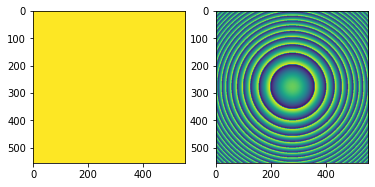

In [ ]:
lens_trans, lens_phase, _, _ = df_fourier.focus_lens_init(propagation_parameters, wavelength_m_aslist=[550e-9], focal_distance_m_aslist=[1e3], focus_offset_m_aslist=[{"x":0, "y":0}])

fig = plt.figure()
ax = df_plt.addAxis(fig,1,2)
ax[0].imshow(lens_trans[0], vmin=0, vmax=1)
ax[1].imshow(lens_phase[0])

As noted previously, the propagation distance here is encoded by the sensor_distance_m parameter (even if it is not the sensor). We initialize the propagation layer and retrieve the output field amplitude and phase. You can read more on the docstrings for the class functions to get an understanding of tensor shapes

In [ ]:
propagator_layer = df_fourier.Propagate_Planes_Layer(propagation_parameters)
ampl, phase = propagator_layer([lens_trans, lens_phase])

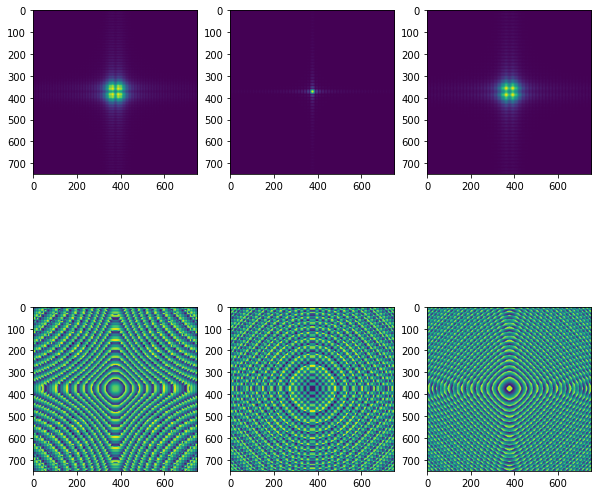

In [ ]:
wavelength_set_m = propagation_parameters["wavelength_set_m"]
num_wl = len(wavelength_set_m)
fig = plt.figure(figsize=(10,10))
ax = df_plt.addAxis(fig,2,num_wl)
for i in range(num_wl):
  ax[i].imshow(ampl[i,0,:,:])
  ax[i+num_wl].imshow(phase[i,0,:,:])

One of the most important things about the D$\flat$ propagators (in addition to being differentiable) is that they correctly conserve energy (up to discretization sum error). You can see this following:

In [ ]:
ms_dx_m = propagation_parameters["ms_dx_m"]
sensor_pixel_size_m = propagation_parameters["sensor_pixel_size_m"]

init_energy = np.sum(lens_trans**2 *  ms_dx_m['x'] * ms_dx_m["y"])
out_energy = np.sum(ampl**2 * sensor_pixel_size_m["x"] * sensor_pixel_size_m["x"], axis=(1,2,3))

print("Energy Ratio: ", out_energy/init_energy)

Energy Ratio:  [0.98346929 0.98268927 0.98193312]


If we want to use radial symmetry, we just pass in a radial vector as the input. Note that if radial calculations are used for field propagations, you will get back a radial vector as the output! This is because you might want to propagate several times and keep the radial symmetry assumption to conserve memory. 

In the next section we will look at the point-spread function calculation layers. In those cases, you will always get back a 2D field regardless of if the input is a radial vector or the 2D spatial field. This is intuitive because you will always need a 2D PSF for rendering (not a radial vector).

I am aware that in the current version, radial_symmetric calculations reduce memory substantialy vs 2D but is actually running slower. The faster version of the algorithm has potential to cause inaccuracies and so a slower, more exact calculation is done which involves some expensive re-interpolation and spline steps.

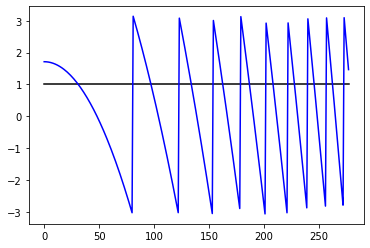

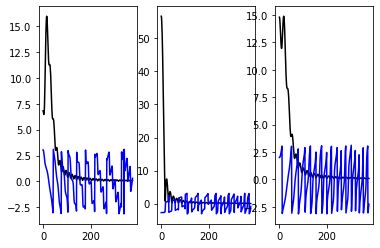

In [ ]:
settings["radial_symmetry"] = True
settings["radius_m"] = 1e-3 / 2
propagation_parameters = df_struct.prop_params(settings)

lens_trans, lens_phase, _, _ = df_fourier.focus_lens_init(propagation_parameters, wavelength_m_aslist=[550e-9], focal_distance_m_aslist=[1e3], focus_offset_m_aslist=[{"x":0, "y":0}])
fig = plt.figure()
ax = df_plt.addAxis(fig,1,1)
ax[0].plot(lens_trans[0,0,:], "k-")
ax[0].plot(lens_phase[0,0,:], "b-")

propagator_layer = df_fourier.Propagate_Planes_Layer(propagation_parameters)
ampl, phase = propagator_layer([lens_trans, lens_phase])

wavelength_set_m = propagation_parameters["wavelength_set_m"]
num_wl = len(wavelength_set_m)
fig = plt.figure()
ax = df_plt.addAxis(fig,1,3)
for i in range(num_wl):
  ax[i].plot(ampl[i,0,0,:], "k-")
  ax[i].plot(phase[i, 0,0,:], "b-")


Energy is conserved in the radial case all the same but you should remember that you cannot check the energy of the field from the radial slice. You should covert the radial profile to 2D. You can use one of D$\flat$'s helper functions to do this. As a note, this conversion is fully differentiable and is used to compute 2D psfs when the radial symmetry assumption is applied. 

In [ ]:
ms_dx_m = propagation_parameters["ms_dx_m"]
sensor_pixel_size_m = propagation_parameters["sensor_pixel_size_m"]

init_energy = np.sum(df_fourier.radial_2d_transform(lens_trans)**2 * ms_dx_m["x"] * ms_dx_m["y"])
out_energy = np.sum(df_fourier.radial_2d_transform(ampl)**2 * sensor_pixel_size_m["x"] * sensor_pixel_size_m["x"], axis=(1,2,3,4))

print("Energy Ratio: ", out_energy/init_energy)

Energy Ratio:  [0.99455893 0.9934385  0.99368713]


# Computing Point-Spread Functions

Computing point-spread functions are done in almost the same way as field-propagation but with a more convenient routine. Here, we will initialize the PSF_Layer (subclass of tf.keras.layers.Layer) to handle psf calculations for a given propagation parameters object.

In [ ]:
settings = {
    "wavelength_set_m": [500e-9, 550e-9, 600e-9],
    "ms_samplesM": {"x": 555, "y": 555},
    "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
    "radius_m": 1e-3/2, # If None, no aperture is used
    "sensor_distance_m": 25e-3,
    "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
    "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
    "sensor_pixel_number": {"x": 501, "y": 501},
    "radial_symmetry": False,
    "diffractionEngine": "ASM_fourier", # Either ASM_fourier or fresnel_Fourier
    ### Optional keys
    "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
    "manual_upsample_factor": 1,  # Otherwise you can manually dictate upsample factor
    }
propagation_parameters = df_struct.prop_params(settings)

psf_layer = df_fourier.PSF_Layer(propagation_parameters)

Again, we will leave the inputs of tensor shapes to the class's docstrings but we will demonstrate it's usage. We can compute the PSF for different wavelengths and for a batch of lenses (which may represent the optical response for two polarization states as an example) for several different point-source locations. 

In [ ]:
# Let us just define on-axis ideal point-sources at different depths
zloc = [0.3, 0.6, 0.9]
point_source_locs = np.array([[0, 0, z] for z in zloc])

# Define two lenses that focus the point source for two different depths (and a particular wavelength)
lens_trans, lens_phase, _, _ = df_fourier.focus_lens_init(propagation_parameters, wavelength_m_aslist=[550e-9, 600e-9], focal_distance_m_aslist=[0.3, 0.6], focus_offset_m_aslist=[{"x":0, "y":0}, {"x":0, "y":0}])

psf_intensity, psf_phase = psf_layer((lens_trans, lens_phase), point_source_locs)
print(psf_intensity.shape)
# Returns output of shape [um_wavelength, num_lenses_batched, num_point_sources, pixelsY, pixelsX]

(3, 2, 3, 501, 501)


Lets visualize what these point-spread functions look like for the two lenses. We know what the answer should be. Each lens should be completely in focus for a particular wavelength and a particular object depth since that was the condition used for the phase profiles!

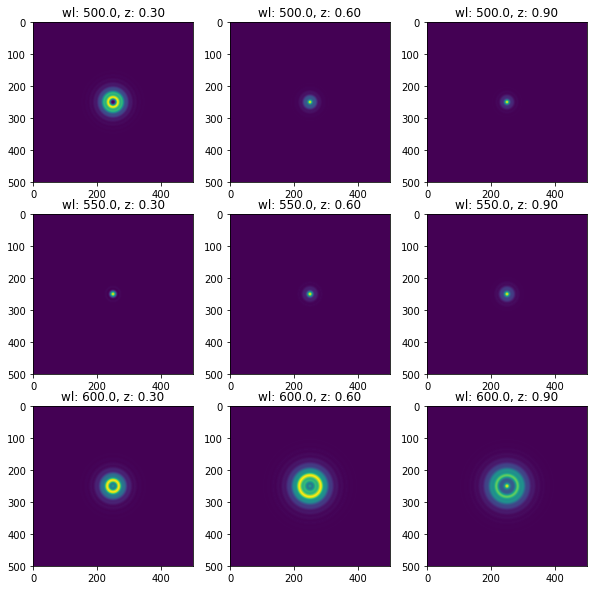

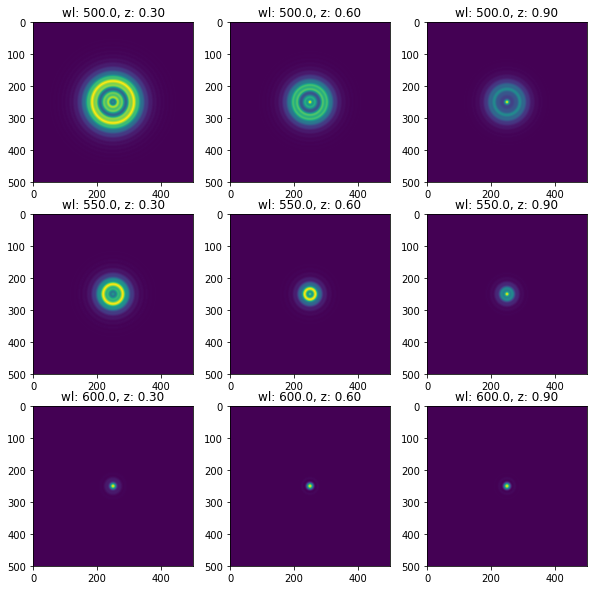

In [ ]:
for lens in range(2):
  # Plot each lens
  fig = plt.figure(figsize=(10,10))
  ax = df_plt.addAxis(fig,3,3)
  counter=0
  for iterL, wl in enumerate(settings["wavelength_set_m"]):
    for iterZ, z in enumerate(zloc):
      ax[counter].imshow(psf_intensity[iterL, lens, iterZ, :,:])
      ax[counter].set_title(f"wl: {wl*1e9}, z: {z:.2f}")
      counter = counter+1  

The computed PSFs are returned by defualt with meaningful normalization. The values depict the intensity at the sensor and are normalized such that the total sum is equal to or less than one (consistent to the theory of PSF rendering). The energy has been normalized to the amount that was incident on the lens. 

In [ ]:
print(np.sum(psf_intensity, axis=(3,4)))

[[[0.98192049 0.98212465 0.98216876]
  [0.98233884 0.98298133 0.98315223]]

 [[0.98117735 0.98112547 0.98108272]
  [0.9823455  0.98267263 0.98275135]]

 [[0.98002199 0.97963077 0.97946037]
  [0.98207743 0.98214404 0.98213712]]]


# Obtaining Gradients of field propagation with autodifferentiation

As all calculations are fully differentiable and built with tensorflow, we can call for the gradients with respect to arbtirary loss functions.

In [ ]:
import tensorflow as tf

In [ ]:
settings = {
    "wavelength_set_m": [600e-9],
    "ms_samplesM": {"x": 555, "y": 555},
    "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
    "radius_m": 1e-3 / 2, # If None, no aperture is used
    "sensor_distance_m": 25e-3,
    "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
    "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
    "sensor_pixel_number": {"x": 501, "y": 501},
    "radial_symmetry": False,
    "diffractionEngine": "ASM_fourier", # Either ASM_fourier or fresnel_Fourier
    ### Optional keys
    "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
    "manual_upsample_factor": 1,  # Otherwise you can manually dictate upsample factor
    }
propagation_parameters = df_struct.prop_params(settings)

# Define a trainable lens phase (and non-trainable transmittance)
lens_trans, lens_phase, _, _ = df_fourier.focus_lens_init(propagation_parameters, wavelength_m_aslist=[600e-9], focal_distance_m_aslist=[0.6], focus_offset_m_aslist=[{"x":-50e-6, "y":50e-6}])
trans_variable = tf.Variable(lens_trans, dtype=tf.float64, trainable=False)
phase_variable = tf.Variable(lens_phase, dtype=tf.float64, trainable=True)

psf_layer = df_fourier.PSF_Layer(propagation_parameters)
point_source_locs = np.array([[0,0,0.6]])
with tf.GradientTape() as tape:
  # Call psf computation
  psf_int, _ = psf_layer((trans_variable, phase_variable), point_source_locs)

  # take a simple objective function
  new_focus_pt_energy = tf.math.reduce_sum(psf_int)

# Get gradients
gradients = tape.gradient(new_focus_pt_energy, [phase_variable])
print(gradients)

[<tf.Tensor: shape=(1, 555, 555), dtype=float64, numpy=
array([[[-1.50658980e-15, -3.02078790e-15, -1.42699608e-15, ...,
          4.86975860e-15,  8.40046910e-15,  8.46685860e-15],
        [-9.85907619e-16, -2.06587099e-15, -8.92509253e-16, ...,
          4.44441191e-15,  7.74218048e-15,  8.40046910e-15],
        [ 6.13617133e-16,  4.42632165e-18, -1.20823749e-17, ...,
          2.49547879e-15,  4.44441192e-15,  4.86975860e-15],
        ...,
        [-5.89359367e-15, -6.17694547e-15, -2.82094613e-15, ...,
         -1.20820246e-17, -8.92509263e-16, -1.42699610e-15],
        [-1.17976774e-14, -1.27842890e-14, -6.17694545e-15, ...,
          4.42629188e-18, -2.06587099e-15, -3.02078790e-15],
        [-1.07257533e-14, -1.17976774e-14, -5.89359365e-15, ...,
          6.13617088e-16, -9.85907620e-16, -1.50658980e-15]]])>]
